In [37]:
import os
import zipfile
from tqdm import tqdm
import itertools
import scipy.stats as ss

#comment out if you don't have cudf installed
%load_ext cudf.pandas 
import pandas as pd

play_df = pd.read_csv('nfl-playing-surface-analytics/PlayList.csv')
player_df = pd.read_csv('nfl-playing-surface-analytics/PlayerTrackData.csv')
injury_df = pd.read_csv('nfl-playing-surface-analytics/InjuryRecord.csv')

# check if gpu is available
!nvidia-smi

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas
Fri Apr  4 22:58:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
| 30%   36C    P0             61W /  450W |   23877MiB /  24564MiB |      5%      Default |
|                                         |       

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
#data preperation
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']]
game_df = game_df.drop_duplicates()
game_df = game_df.reset_index(drop = True)

# --- Helper function to clean Weather descriptions ---
def clean_weather(row):
    """
    Map messy weather descriptions into consistent categories: 
    'Clear', 'Cloudy', 'Rain', 'Snow', 'Indoor', or NaN.
    
    Args:
        row (Series): Row from the dataframe with a 'Weather' column.
        
    Returns:
        str or np.nan: Cleaned weather category.
    """
    cloudy_conditions = [
        'Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
        'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
        'Mostly cloudy', 'Rain Chance 40%', ' Partly cloudy', 'Party Cloudy',
        'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain',
        'Mostly Coudy', '10% Chance of Rain', 'Cloudy, chance of rain', 
        '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"', 'cloudy', 
        'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
        'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy and cold', 'Cloudy and Cool', 'Partly cloudy'
    ]

    clear_conditions = [
        'Clear, Windy', 'Clear to Cloudy', 'Clear, highs to upper 80s', 'Clear and clear',
        'Partly sunny', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny',
        'Clear Skies', 'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s',
        'Sun & clouds', 'Mostly sunny', 'Sunny, Windy', 'Mostly Sunny Skies',
        'Clear and Sunny', 'Clear and sunny', 'Clear to Partly Cloudy', 'Clear Skies',
        'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold',
        'Sunny and warm', 'Sunny and clear'
    ]

    rainy_conditions = [
        'Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 
        'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain'
    ]

    snow_conditions = ['Heavy lake effect snow']

    indoor_conditions = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    # Map the raw Weather values to categories
    if row.Weather in cloudy_conditions:
        return 'Cloudy'
    if row.Weather in indoor_conditions:
        return 'Indoor'
    if row.Weather in clear_conditions:
        return 'Clear'
    if row.Weather in rainy_conditions:
        return 'Rain'
    if row.Weather in snow_conditions:
        return 'Snow'
    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    # If not recognized, return the original
    return row.Weather

# --- Helper function to clean StadiumType descriptions ---
def clean_stadiumtype(row):
    """
    Clean specific StadiumType anomalies by setting them to NaN.
    
    Args:
        row (Series): Row from the dataframe with a 'StadiumType' column.
        
    Returns:
        str or np.nan: Cleaned stadium type.
    """
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

# --- Main function to clean the dataframe ---
def clean_play_df(play_df):
    """
    Clean 'StadiumType' and 'Weather' fields of a play-level dataframe.
    
    Args:
        play_df (DataFrame): Raw input play dataframe.
        
    Returns:
        DataFrame: Cleaned play dataframe.
    """
    play_df_cleaned = play_df.copy()

    # --- Clean StadiumType ---
    # Standardize common StadiumType misspellings or formats using regex
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 
        'Retractable Roof', regex=True
    )
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(
        'Open', 'Outdoor', regex=False
    )

    # Apply StadiumType anomaly cleaning
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(clean_stadiumtype, axis=1)

    # --- Clean Weather ---
    play_df_cleaned['Weather'] = play_df_cleaned.apply(clean_weather, axis=1)

    return play_df_cleaned

play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']]
game_df_cleaned = game_df_cleaned.drop_duplicates()
game_df_cleaned = game_df_cleaned.reset_index(drop = True)

# --- Join cleaned game dataset with injury dataset ---
game_injury_df = (
    injury_df.set_index('GameID')
    .join(game_df_cleaned.set_index('GameID'), how='outer')
)

# --- Fill missing injury columns with zeros and convert to integer ---
for col in ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']:
    game_injury_df[col] = game_injury_df[col].fillna(0).astype(int)

# --- Adjust injury metrics by subtracting later windows ---
game_injury_df['DM_M1']  = game_injury_df['DM_M1']  - game_injury_df['DM_M7']
game_injury_df['DM_M7']  = game_injury_df['DM_M7']  - game_injury_df['DM_M28']
game_injury_df['DM_M28'] = game_injury_df['DM_M28'] - game_injury_df['DM_M42']

# --- Introduce an 'Injury' flag indicating any injury ---
game_injury_df['Injury'] = (
    game_injury_df['DM_M1'] +
    game_injury_df['DM_M7'] +
    game_injury_df['DM_M28'] +
    game_injury_df['DM_M42']
)

# --- Drop unnecessary columns ---
game_injury_df = game_injury_df.drop(columns=['Surface', 'PlayerKey', 'PlayKey']).copy()

# --- Create dummy variables (one-hot encoding) ---
game_injury_df_dummies = (
    pd.get_dummies(game_injury_df, dummy_na=True, drop_first=True)
    .drop(columns=['FieldType_nan'])
)

# --- Join cleaned play dataset with injury dataset on PlayKey ---
play_injury_df = (
    injury_df.dropna(subset=['PlayKey'])
    .set_index('PlayKey')
    .join(
        play_df_cleaned.set_index('PlayKey'), 
        how='outer', 
        lsuffix='_left', 
        rsuffix='_right'
    )
)

# --- Fill missing injury columns with zeros and convert to integer ---
for col in ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']:
    play_injury_df[col] = play_injury_df[col].fillna(0).astype(int)

# --- Adjust injury metrics by subtracting later windows ---
play_injury_df['DM_M1']  = play_injury_df['DM_M1']  - play_injury_df['DM_M7']
play_injury_df['DM_M7']  = play_injury_df['DM_M7']  - play_injury_df['DM_M28']
play_injury_df['DM_M28'] = play_injury_df['DM_M28'] - play_injury_df['DM_M42']

# --- Introduce an 'Injury' flag indicating any injury occurrence ---
play_injury_df['Injury'] = (
    play_injury_df['DM_M1'] +
    play_injury_df['DM_M7'] +
    play_injury_df['DM_M28'] +
    play_injury_df['DM_M42']
)

# --- Drop duplicated surface column (already exists elsewhere) ---
play_injury_df = play_injury_df.drop(columns=['Surface']).copy()

# --- Create dummy variables for PlayType and PositionGroup ---
play_injury_df_dummies = pd.get_dummies(
    play_injury_df,
    columns=['PlayType', 'PositionGroup'],
    dummy_na=True,
    drop_first=True
)

# create motion_df
def create_motion_data_df(injury_df, play_df, player_df):
    """
    Create a motion-aggregated dataframe by combining player, play, and injury data.

    Args:
        injury_df (DataFrame): Injury-level dataset.
        play_df (DataFrame): Play-level dataset.
        player_df (DataFrame): Player tracking dataset (includes motion features).

    Returns:
        DataFrame: Merged dataset with motion data aggregated at the play level.
    """
    # --- Create a new field: angle between orientation and direction ---
    player_df['angle'] = player_df['o'] - player_df['dir']

    # --- Group motion features by PlayKey ---
    # Maximum values per play
    grouped_max = (
        player_df[['PlayKey', 'time', 'dir', 'dis', 'o', 's', 'angle']]
        .groupby('PlayKey')
        .max()
    )

    # Average values per play
    grouped_avg = (
        player_df[['PlayKey', 'time', 'dir', 'dis', 'o', 's', 'angle']]
        .groupby('PlayKey')
        .mean()
    )

    # --- Merge aggregated motion features back into play data ---
    play_df = play_df.merge(
        grouped_max.reset_index(),
        on='PlayKey'
    ).merge(
        grouped_avg.reset_index(),
        on='PlayKey',
        suffixes=('_max', '_avg')
    )

    # --- Merge with injury data (dropping unnecessary columns first) ---
    injury_df_cleaned = injury_df.drop(
        columns=['PlayerKey', 'GameID', 'BodyPart', 'Surface']
    )

    merged_df = injury_df_cleaned.merge(
        play_df, on='PlayKey', how='outer'
    ).fillna(0)

    return merged_df

#create motion_df
motion_df = create_motion_data_df(injury_df, play_df, player_df)
# Select injury columns automatically
injury_cols = [col for col in motion_df.columns if col.startswith('DM_M')]

# Sum across them to create the Injury flag
motion_df['Injury'] = motion_df[injury_cols].sum(axis=1)

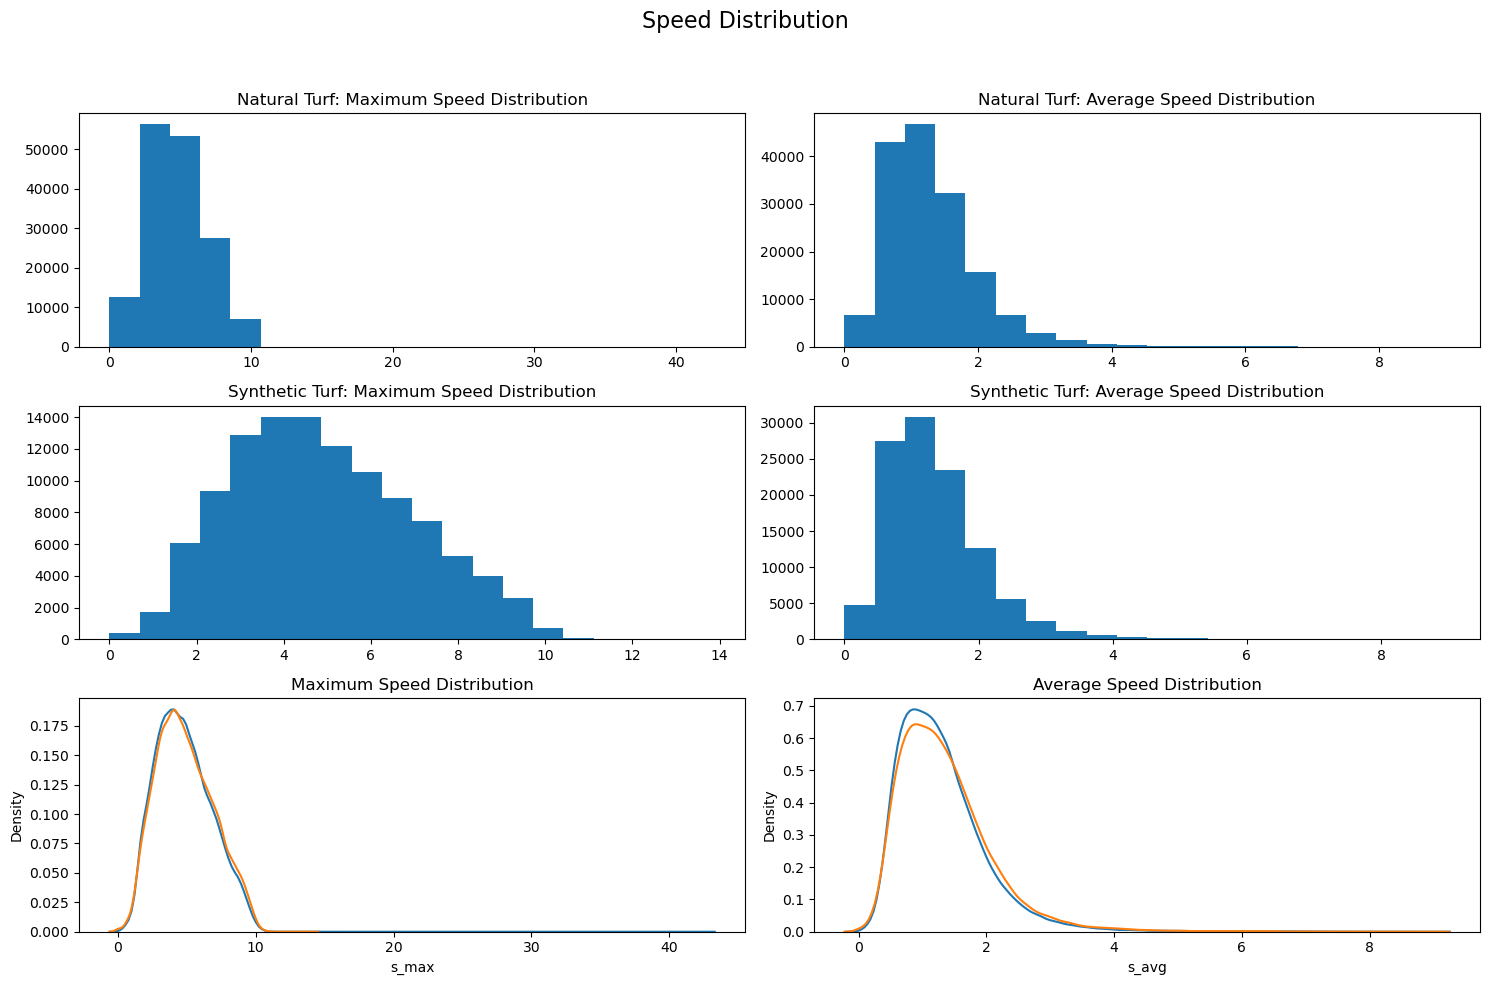

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

axs[0, 0].hist(
    motion_df[motion_df['FieldType'] == 'Natural']['s_max'],
    bins=20
)
axs[0, 0].set_title('Natural Turf: Maximum Speed Distribution')

axs[1, 0].hist(
    motion_df[motion_df['FieldType'] == 'Synthetic']['s_max'],
    bins=20
)
axs[1, 0].set_title('Synthetic Turf: Maximum Speed Distribution')

axs[0, 1].hist(
    motion_df[motion_df['FieldType'] == 'Natural']['s_avg'],
    bins=20
)
axs[0, 1].set_title('Natural Turf: Average Speed Distribution')

axs[1, 1].hist(
    motion_df[motion_df['FieldType'] == 'Synthetic']['s_avg'],
    bins=20
)
axs[1, 1].set_title('Synthetic Turf: Average Speed Distribution')

sns.kdeplot(
    data=motion_df[motion_df['FieldType'] == 'Natural'],
    x='s_max',
    ax=axs[2, 0],
    label='Natural'
)
sns.kdeplot(
    data=motion_df[motion_df['FieldType'] == 'Synthetic'],
    x='s_max',
    ax=axs[2, 0],
    label='Synthetic'
)
axs[2, 0].set_title('Maximum Speed Distribution')

sns.kdeplot(
    data=motion_df[motion_df['FieldType'] == 'Natural'],
    x='s_avg',
    ax=axs[2, 1],
    label='Natural'
)
sns.kdeplot(
    data=motion_df[motion_df['FieldType'] == 'Synthetic'],
    x='s_avg',
    ax=axs[2, 1],
    label='Synthetic'
)
axs[2, 1].set_title('Average Speed Distribution')

plt.suptitle('Speed Distribution', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [42]:
X.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 266989 entries, 0 to 266988
Columns: 161 entries, PlayerDay to PositionGroup_WR
dtypes: bool(145), float64(12), int64(4)
memory usage: 69.5 MB


In [43]:
y_pred = model.predict(X_test)

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80062
           1       0.44      0.44      0.44         9
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6

    accuracy                           1.00     80097
   macro avg       0.29      0.29      0.29     80097
weighted avg       1.00      1.00      1.00     80097



/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [46]:
X.columns

Index(['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay', 'time_max',
       'dir_max', 'dis_max', 'o_max', 's_max', 'angle_max',
       ...
       'Position_WR', 'PositionGroup_DB', 'PositionGroup_DL',
       'PositionGroup_LB', 'PositionGroup_OL', 'PositionGroup_QB',
       'PositionGroup_RB', 'PositionGroup_SPEC', 'PositionGroup_TE',
       'PositionGroup_WR'],
      dtype='object', length=161)

[0]	validation_0-auc:0.74454
[1]	validation_0-auc:0.75657
[2]	validation_0-auc:0.73938
[3]	validation_0-auc:0.72064
[4]	validation_0-auc:0.70557
[5]	validation_0-auc:0.70610
[6]	validation_0-auc:0.69946
[7]	validation_0-auc:0.69169
[8]	validation_0-auc:0.68544
[9]	validation_0-auc:0.68796
[10]	validation_0-auc:0.69095
[11]	validation_0-auc:0.68912
[12]	validation_0-auc:0.68131
[13]	validation_0-auc:0.68351
[14]	validation_0-auc:0.67736
[15]	validation_0-auc:0.67615
[16]	validation_0-auc:0.67899
[17]	validation_0-auc:0.68038
[18]	validation_0-auc:0.68769
[19]	validation_0-auc:0.68682
[20]	validation_0-auc:0.68314
[21]	validation_0-auc:0.68252
[22]	validation_0-auc:0.67935
[23]	validation_0-auc:0.68512
[24]	validation_0-auc:0.67790
[25]	validation_0-auc:0.67446
[26]	validation_0-auc:0.67591
[27]	validation_0-auc:0.67966
[28]	validation_0-auc:0.67844
[29]	validation_0-auc:0.67842
[30]	validation_0-auc:0.68139
[31]	validation_0-auc:0.68182
[32]	validation_0-auc:0.68730
[33]	validation_0-au

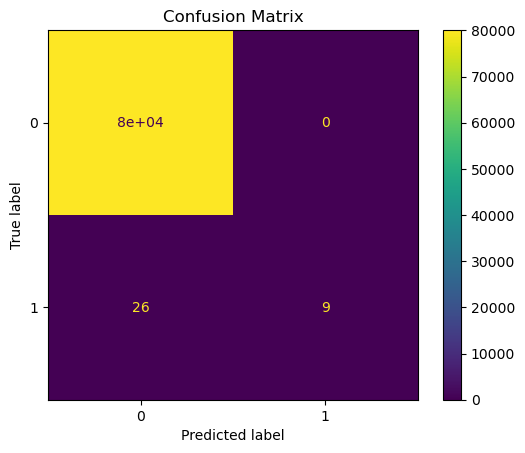

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Prepare the features (drop leakage columns)
X = motion_df.drop(columns=[
    'Injury', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'PlayKey', 'PlayerKey', 'GameID'
])

# 2. One-hot encode categorical columns
X = pd.get_dummies(X, dummy_na=True, drop_first=True)

# 3. Prepare the binary target (0 = no injury, 1 = injury)
y = motion_df['Injury'].copy()
y_binary = y.copy()
y_binary[y_binary > 0] = 1

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42
)

# 5. Compute class imbalance weight
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

# 6. Define the XGBoost model
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',        # Use GPU acceleration
    eval_metric='auc',
    scale_pos_weight=pos_weight    # Handle imbalance
)

# 7. Train the model
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# 8. Predict and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


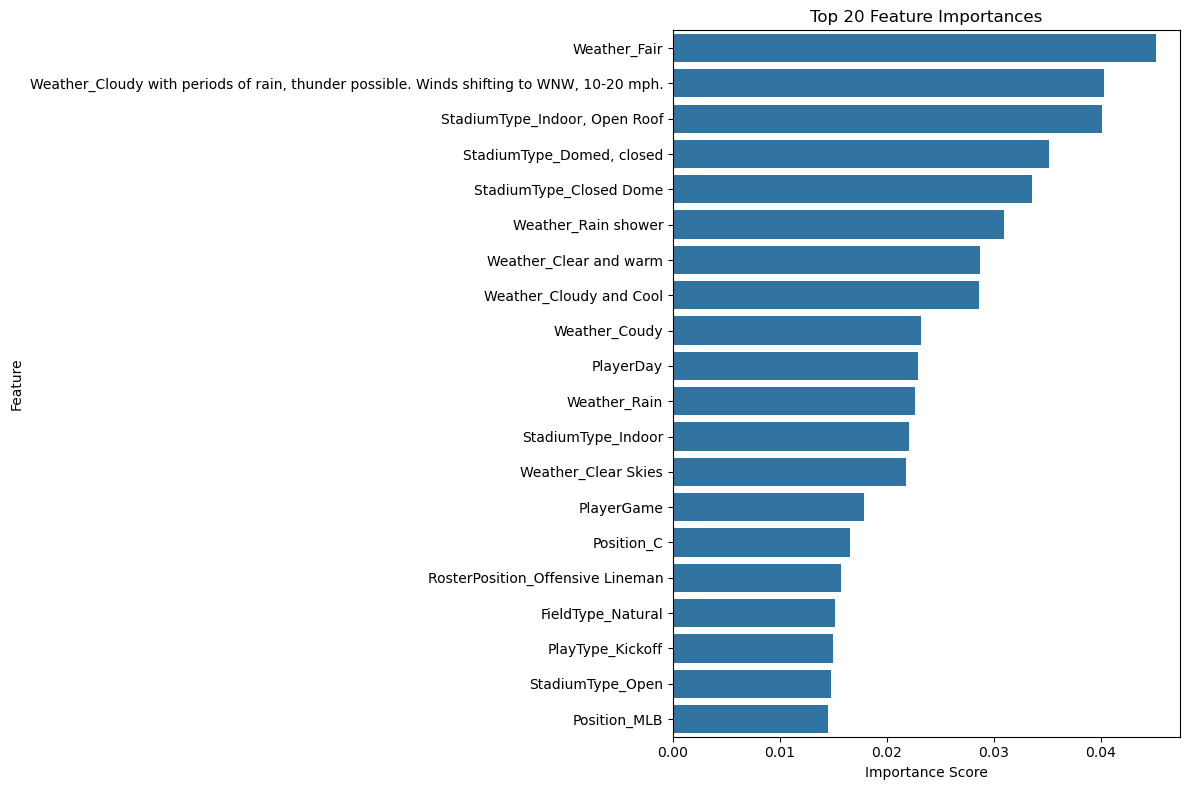

In [48]:
import seaborn as sns

# Get feature importance scores
importances = model.feature_importances_

# Match them to feature names
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(20)  # Top 20 features
)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [51]:
y_binary.value_counts()

Injury
0    266884
1       105
Name: count, dtype: int64